In [1]:
import torch

# 1. 버전 확인
print(f"Torch Version: {torch.__version__}")

# 2. GPU 인식 여부 (True가 나와야 성공)
print(f"CUDA Available: {torch.cuda.is_available()}")

# 3. GPU 이름 출력
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Torch Version: 2.11.0.dev20260211+cu130
CUDA Available: True
Device Name: NVIDIA GeForce RTX 5060


In [2]:
import pandas as pd
import numpy as np
import torch
torch.set_float32_matmul_precision('medium')
import lightning.pytorch as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

W0212 17:44:19.486000 12032 site-packages\torch\utils\flop_counter.py:29] triton not found; flop counting will not work for triton kernels
c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\pytorch_forecasting\models\base\_base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
data = pd.read_csv('sales_data.csv')
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [4]:
df = data.copy()

# Change 'Date' to datetime and sort by Store ID, Product ID, and Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

# Create time index for TFT
df['time_idx'] = (df['Date'] - df['Date'].min()).dt.days

# Convert categorical variables to string type for TFT
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
for col in categorical_cols:
    df[col] = df[col].astype(str)

# Extract date features
df['Month'] = df['Date'].dt.month.astype(str)
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype(str)

# Log-transform the target variable, inventory level and units ordered
df['Demand'] = np.log1p(df['Demand'])
df['Inventory Level'] = np.log1p(df['Inventory Level']) 
df['Units Ordered'] = np.log1p(df['Units Ordered'])

# Drop 'Units Sold' to avoid data leakage      
if 'Units Sold' in df.columns:
    df.drop(columns=['Units Sold'], inplace=True)

print("TFT data preprocessing completed")
print("========================================")
print(df[['Store ID', 'Date', 'time_idx', 'Demand']].head())

TFT data preprocessing completed
  Store ID       Date  time_idx    Demand
0     S001 2022-01-01         0  4.753590
1     S001 2022-01-02         1  4.442651
2     S001 2022-01-03         2  4.890349
3     S001 2022-01-04         3  4.219508
4     S001 2022-01-05         4  4.709530


In [13]:
max_prediction_length = 30
max_encoder_length = 90
training_cutoff = df['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],

    time_idx='time_idx',
    target='Demand',
    
    group_ids=['Store ID', 'Product ID'],

    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    static_categoricals=["Store ID", "Product ID", "Category", "Region"],

    time_varying_known_categoricals=["Month", "DayOfWeek", "Seasonality"],
    time_varying_known_reals=["time_idx", "Price", "Promotion", "Discount", "Competitor Pricing"],

    time_varying_unknown_categoricals=["Weather Condition"],
    time_varying_unknown_reals=["Demand", "Inventory Level", "Epidemic"],

    target_normalizer=GroupNormalizer(groups=["Store ID", "Product ID"], transformation="softplus"),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [6]:
pl.seed_everything(42)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,           
    attention_head_size=4,    
    dropout=0.1,              
    hidden_continuous_size=16,
    output_size=7,            
    loss=QuantileLoss(),      
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

print(f"모델 파라미터 수: {tft.size()/1e3:.1f}k")

logger = TensorBoardLogger("lightning_logs", name="tft_demand_forecasting")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1, 
    logger=logger,
    callbacks=[
        EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"),
        LearningRateMonitor()
    ],
    enable_model_summary=True,
)

print("🚀 Start TFT Learning...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
print("✅ Learning Complete!")

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Seed set to 42
c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:213: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:213: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/l

모델 파라미터 수: 92.5k
🚀 Start TFT Learning...



   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 363    | train | 0    
3  | prescalers                         | ModuleDict                      | 384    | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 6.5 K  | train | 0    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 19.9 K | train | 0    
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.8 K | train | 0    
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train | 0    
8  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 29: 100%|██████████| 1185/1185 [02:37<00:00,  7.50it/s, v_num=0, train_loss_step=0.0364, val_loss=0.0453, train_loss_epoch=0.0348]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1185/1185 [02:38<00:00,  7.50it/s, v_num=0, train_loss_step=0.0364, val_loss=0.0453, train_loss_epoch=0.0348]
✅ Learning Complete!


c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:213: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:213: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [7]:
# 텐서보드 확장 프로그램 로드
%load_ext tensorboard

# 텐서보드 실행 (로그 디렉토리 지정)
%tensorboard --logdir lightning_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\kyle0\miniconda3\envs\my_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\kyle0\miniconda3\envs\my_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\kyle0\miniconda3\envs\my_env\Scripts\tensorboard.exe\__main__.py", line 2, in <module>
  File "C:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\kyle0\miniconda3\envs\my_env\lib\site-packages\tensorboard\default.py", line 30, in <module>
    import pkg_resources
ModuleNotFoundError: No module named 'pkg_resources'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ImportError: plot_prediction requires matplotlib. Please install matplotlib with `pip install matplotlib`.

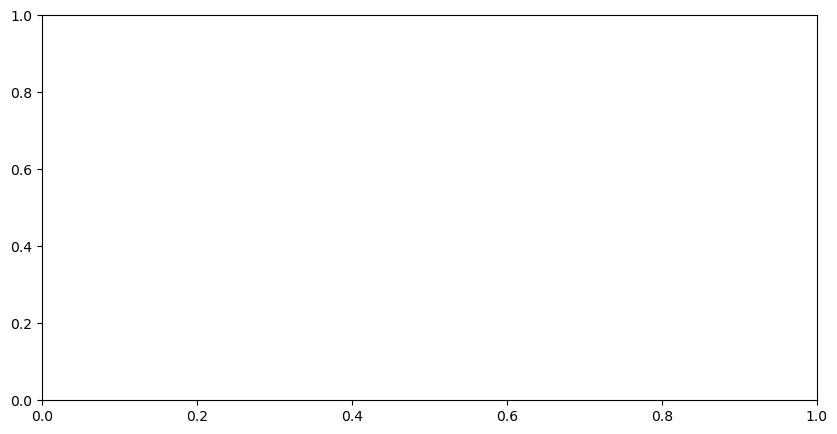

In [15]:
# ====================================================
# 4. 예측 및 시각화 (Prediction & Visualization)
# ====================================================

# 검증 데이터에 대한 예측 수행
# mode="prediction" (점 추정), mode="quantiles" (구간 추정), mode="raw" (전체)
predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# 예측값 추출 (로그 스케일 -> 실제 스케일 변환)
# output.prediction은 기본적으로 Median(0.5 quantile) 혹은 Mean을 반환
pred_raw = predictions.output
pred_median = np.expm1(pred_raw.prediction.cpu().numpy()) 

# 신뢰구간 추출 (Quantiles)
# output_size=7일 때, 인덱스: 0(0.02), 1(0.1), 2(0.25), 3(0.5), 4(0.75), 5(0.9), 6(0.98)
# 95% 신뢰구간 = 하위 2.5%(인덱스 0 근사) ~ 상위 97.5%(인덱스 6 근사)
pred_lower = np.expm1(pred_raw.prediction[:, :, 0].cpu().numpy()) 
pred_upper = np.expm1(pred_raw.prediction[:, :, 6].cpu().numpy())

# 실제값 추출 (첫 번째 타임스텝의 실제값)
# 주의: TFT의 dataloader는 윈도우 방식으로 데이터를 뱉으므로 실제값 정렬에 주의해야 함
actuals = np.expm1(torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu().numpy())

# --- 결과 시각화 (Sample Plot) ---
import matplotlib.pyplot as plt

# TFT 내장 플로팅 기능 사용 (랜덤 샘플 3개)
for idx in range(3): 
    fig, ax = plt.subplots(figsize=(10, 5))
    best_tft.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True, ax=ax)
    plt.title(f"Sample Prediction {idx+1}")
    plt.show()

# --- 변수 중요도 (Interpretation) ---
# TFT의 강력한 장점: 해석력
interpretation = best_tft.interpret_output(predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)
plt.show()